In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.tensorboard.writer import SummaryWriter

from common import data
from common.training import get_predictions

from algos import stoc
from algos import cbl

from common.models import simple_conv
from common import metrics
from common.models.modutils import load_model


c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [9]:
log_dir = "./final/stoc"

horizon = 256
stride = 3 * (horizon // 4)

batch_size = 8

num_epochs = [1, 2, 5, 10, 20, 50, 100, 500]
out_feats = 64
k = 3
gamma = 0.05

learning_rate = 1e-2

weight_decay = 1e-1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
"""
../data/r216n09.gzip - 16388 timesteps - 3.76% anomalies - len seq anomal 4.9
../data/r229n10.gzip - 13239 timesteps - 4.21% anomalies - len seq anomal 4.6
../data/r233n14.gzip - 15384 timesteps - 3.66% anomalies - len seq anomal 4.8
../data/r245n15.gzip - 14874 timesteps - 4.04% anomalies - len seq anomal 4.7
"""
train = ["../data/r216n09.gzip", "../data/r245n15.gzip"]
test = ["../data/r233n14.gzip"]
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


In [10]:
train_dataset = data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride)
test_dataset = data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride)

print(len(train_dataset), len(test_dataset))

164 80


In [11]:
base_width = 128
down_layers = 3
dilations = [False, True, True]

backbone = simple_conv.Encoder(data.NUM_FEATURES, down_layers, base_width, dilations)
model = simple_conv.SimpleConv(backbone, out_feats, horizon)

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, sum(num_epochs))

aug = cbl.pipeline(
    cbl.random_apply(cbl.left_to_right_flipping(1), 0.5),
    cbl.random_apply(cbl.crop_and_resize(1.5, 3), 0.8),
)

engine = cbl.CBLEngine(
    model=model,
    optimizer=optim,
    temperature=0.5,
    aug_1=aug,
    aug_2=aug,
    lr_scheduler=lr_sched,
    device=device,
)

stoc_engine = stoc.STOC(engine, gamma)


In [12]:
with SummaryWriter(log_dir + "/logs") as writer:
    stoc_engine.fit(
        train_dataset,
        test_dataset,
        batch_size,
        k,
        num_epochs,
        writer=writer,
        save_path=log_dir + "/models",
    )


# stoc_engine.fit(train_dataset, test_dataset, batch_size, k, num_epochs)

Iteration 0 - Epoch 0 - train_loss=1.676 - test_loss=2.641 - lr=1.00e-02


Iteration 1 - Epoch 0 - train_loss=1.532 - test_loss=2.665 - lr=1.00e-02


Iteration 1 - Epoch 1 - train_loss=1.420 - test_loss=2.662 - lr=1.00e-02


Iteration 2 - Epoch 0 - train_loss=1.976 - test_loss=2.400 - lr=1.00e-02


Iteration 2 - Epoch 1 - train_loss=1.868 - test_loss=2.399 - lr=1.00e-02


Iteration 2 - Epoch 2 - train_loss=1.907 - test_loss=2.400 - lr=1.00e-02


Iteration 2 - Epoch 3 - train_loss=1.660 - test_loss=2.313 - lr=1.00e-02


Iteration 2 - Epoch 4 - train_loss=1.540 - test_loss=2.275 - lr=1.00e-02


Iteration 3 - Epoch 0 - train_loss=1.232 - test_loss=2.352 - lr=1.00e-02


Iteration 3 - Epoch 1 - train_loss=0.986 - test_loss=2.190 - lr=1.00e-02


Iteration 3 - Epoch 2 - train_loss=0.789 - test_loss=2.396 - lr=9.99e-03


Iteration 3 - Epoch 3 - train_loss=0.631 - test_loss=2.377 - lr=9.99e-03


Iteration 3 - Epoch 4 - train_loss=0.505 - test_loss=2.332 - lr=9.99e-03


Iteration 3 - Epoch 5 - train_loss=0.404 - test_loss=2.395 - lr=9.99e-03


Iteration 3 - Epoch 6 - train_loss=0.323 - test_loss=2.369 - lr=9.99e-03


Iteration 3 - Epoch 7 - train_loss=0.258 - test_loss=2.358 - lr=9.99e-03


Iteration 3 - Epoch 8 - train_loss=0.207 - test_loss=2.424 - lr=9.99e-03


Iteration 3 - Epoch 9 - train_loss=0.165 - test_loss=2.388 - lr=9.98e-03


Iteration 4 - Epoch 0 - train_loss=1.534 - test_loss=2.386 - lr=9.98e-03


Iteration 4 - Epoch 1 - train_loss=1.543 - test_loss=2.440 - lr=9.98e-03


Iteration 4 - Epoch 2 - train_loss=1.392 - test_loss=2.367 - lr=9.98e-03


Iteration 4 - Epoch 3 - train_loss=1.292 - test_loss=2.431 - lr=9.98e-03


Iteration 4 - Epoch 4 - train_loss=1.340 - test_loss=2.351 - lr=9.97e-03


Iteration 4 - Epoch 5 - train_loss=1.317 - test_loss=2.297 - lr=9.97e-03


Iteration 4 - Epoch 6 - train_loss=1.339 - test_loss=2.303 - lr=9.97e-03


Iteration 4 - Epoch 7 - train_loss=1.294 - test_loss=2.395 - lr=9.97e-03


Iteration 4 - Epoch 8 - train_loss=1.283 - test_loss=2.352 - lr=9.96e-03


Iteration 4 - Epoch 9 - train_loss=1.316 - test_loss=2.360 - lr=9.96e-03


Iteration 4 - Epoch 10 - train_loss=1.287 - test_loss=2.366 - lr=9.96e-03


Iteration 4 - Epoch 11 - train_loss=1.310 - test_loss=2.431 - lr=9.96e-03


Iteration 4 - Epoch 12 - train_loss=1.298 - test_loss=2.401 - lr=9.95e-03


Iteration 4 - Epoch 13 - train_loss=1.205 - test_loss=2.399 - lr=9.95e-03


Iteration 4 - Epoch 14 - train_loss=1.219 - test_loss=2.314 - lr=9.95e-03


Iteration 4 - Epoch 15 - train_loss=1.355 - test_loss=2.384 - lr=9.94e-03


Iteration 4 - Epoch 16 - train_loss=1.195 - test_loss=2.338 - lr=9.94e-03


Iteration 4 - Epoch 17 - train_loss=1.218 - test_loss=2.340 - lr=9.94e-03


Iteration 4 - Epoch 18 - train_loss=1.167 - test_loss=2.340 - lr=9.93e-03


Iteration 4 - Epoch 19 - train_loss=1.178 - test_loss=2.339 - lr=9.93e-03


Iteration 5 - Epoch 0 - train_loss=1.240 - test_loss=2.420 - lr=9.92e-03


Iteration 5 - Epoch 1 - train_loss=1.288 - test_loss=2.390 - lr=9.92e-03


Iteration 5 - Epoch 2 - train_loss=1.324 - test_loss=2.407 - lr=9.92e-03


Iteration 5 - Epoch 3 - train_loss=1.357 - test_loss=2.338 - lr=9.91e-03


Iteration 5 - Epoch 4 - train_loss=1.325 - test_loss=2.357 - lr=9.91e-03


Iteration 5 - Epoch 5 - train_loss=1.341 - test_loss=2.340 - lr=9.90e-03


Iteration 5 - Epoch 6 - train_loss=1.362 - test_loss=2.349 - lr=9.90e-03


Iteration 5 - Epoch 7 - train_loss=1.354 - test_loss=2.329 - lr=9.89e-03


Iteration 5 - Epoch 8 - train_loss=1.355 - test_loss=2.305 - lr=9.89e-03


Iteration 5 - Epoch 9 - train_loss=1.355 - test_loss=2.336 - lr=9.89e-03


Iteration 5 - Epoch 10 - train_loss=1.339 - test_loss=2.339 - lr=9.88e-03


Iteration 5 - Epoch 11 - train_loss=1.336 - test_loss=2.366 - lr=9.88e-03


Iteration 5 - Epoch 12 - train_loss=1.338 - test_loss=2.342 - lr=9.87e-03


Iteration 5 - Epoch 13 - train_loss=1.333 - test_loss=2.367 - lr=9.87e-03


Iteration 5 - Epoch 14 - train_loss=1.324 - test_loss=2.197 - lr=9.86e-03


Iteration 5 - Epoch 15 - train_loss=1.300 - test_loss=2.300 - lr=9.85e-03


Iteration 5 - Epoch 16 - train_loss=1.300 - test_loss=2.323 - lr=9.85e-03


Iteration 5 - Epoch 17 - train_loss=1.293 - test_loss=2.269 - lr=9.84e-03


Iteration 5 - Epoch 18 - train_loss=1.302 - test_loss=2.258 - lr=9.84e-03


Iteration 5 - Epoch 19 - train_loss=1.296 - test_loss=2.247 - lr=9.83e-03


Iteration 5 - Epoch 20 - train_loss=1.289 - test_loss=2.354 - lr=9.83e-03


Iteration 5 - Epoch 21 - train_loss=1.289 - test_loss=2.293 - lr=9.82e-03


Iteration 5 - Epoch 22 - train_loss=1.308 - test_loss=2.348 - lr=9.81e-03


Iteration 5 - Epoch 23 - train_loss=1.295 - test_loss=2.336 - lr=9.81e-03


Iteration 5 - Epoch 24 - train_loss=1.276 - test_loss=2.213 - lr=9.80e-03


Iteration 5 - Epoch 25 - train_loss=1.273 - test_loss=2.360 - lr=9.79e-03


Iteration 5 - Epoch 26 - train_loss=1.256 - test_loss=2.346 - lr=9.79e-03


Iteration 5 - Epoch 27 - train_loss=1.265 - test_loss=2.328 - lr=9.78e-03


Iteration 5 - Epoch 28 - train_loss=1.265 - test_loss=2.378 - lr=9.77e-03


Iteration 5 - Epoch 29 - train_loss=1.258 - test_loss=2.322 - lr=9.77e-03


Iteration 5 - Epoch 30 - train_loss=1.255 - test_loss=2.338 - lr=9.76e-03


Iteration 5 - Epoch 31 - train_loss=1.234 - test_loss=2.348 - lr=9.75e-03


Iteration 5 - Epoch 32 - train_loss=1.230 - test_loss=2.360 - lr=9.75e-03


Iteration 5 - Epoch 33 - train_loss=1.228 - test_loss=2.405 - lr=9.74e-03


Iteration 5 - Epoch 34 - train_loss=1.232 - test_loss=2.348 - lr=9.73e-03


Iteration 5 - Epoch 35 - train_loss=1.215 - test_loss=2.351 - lr=9.72e-03


Iteration 5 - Epoch 36 - train_loss=1.233 - test_loss=2.299 - lr=9.72e-03


Iteration 5 - Epoch 37 - train_loss=1.242 - test_loss=2.371 - lr=9.71e-03


Iteration 5 - Epoch 38 - train_loss=1.237 - test_loss=2.322 - lr=9.70e-03


Iteration 5 - Epoch 39 - train_loss=1.240 - test_loss=2.243 - lr=9.69e-03


Iteration 5 - Epoch 40 - train_loss=1.258 - test_loss=2.297 - lr=9.69e-03


Iteration 5 - Epoch 41 - train_loss=1.257 - test_loss=2.319 - lr=9.68e-03


Iteration 5 - Epoch 42 - train_loss=1.260 - test_loss=2.318 - lr=9.67e-03


Iteration 5 - Epoch 43 - train_loss=1.243 - test_loss=2.316 - lr=9.66e-03


Iteration 5 - Epoch 44 - train_loss=1.228 - test_loss=2.352 - lr=9.65e-03


Iteration 5 - Epoch 45 - train_loss=1.235 - test_loss=2.327 - lr=9.65e-03


Iteration 5 - Epoch 46 - train_loss=1.221 - test_loss=2.321 - lr=9.64e-03


Iteration 5 - Epoch 47 - train_loss=1.217 - test_loss=2.350 - lr=9.63e-03


Iteration 5 - Epoch 48 - train_loss=1.200 - test_loss=2.368 - lr=9.62e-03


Iteration 5 - Epoch 49 - train_loss=1.187 - test_loss=2.383 - lr=9.61e-03


Iteration 6 - Epoch 0 - train_loss=1.225 - test_loss=2.374 - lr=9.60e-03


Iteration 6 - Epoch 1 - train_loss=1.338 - test_loss=2.362 - lr=9.59e-03


Iteration 6 - Epoch 2 - train_loss=1.134 - test_loss=2.375 - lr=9.58e-03


Iteration 6 - Epoch 3 - train_loss=1.288 - test_loss=2.414 - lr=9.57e-03


Iteration 6 - Epoch 4 - train_loss=1.303 - test_loss=2.297 - lr=9.57e-03


Iteration 6 - Epoch 5 - train_loss=1.189 - test_loss=2.398 - lr=9.56e-03


Iteration 6 - Epoch 6 - train_loss=1.144 - test_loss=2.387 - lr=9.55e-03


Iteration 6 - Epoch 7 - train_loss=1.133 - test_loss=2.414 - lr=9.54e-03


Iteration 6 - Epoch 8 - train_loss=1.148 - test_loss=2.318 - lr=9.53e-03


Iteration 6 - Epoch 9 - train_loss=1.138 - test_loss=2.341 - lr=9.52e-03


Iteration 6 - Epoch 10 - train_loss=1.181 - test_loss=2.358 - lr=9.51e-03


Iteration 6 - Epoch 11 - train_loss=1.119 - test_loss=2.376 - lr=9.50e-03


Iteration 6 - Epoch 12 - train_loss=1.126 - test_loss=2.330 - lr=9.49e-03


Iteration 6 - Epoch 13 - train_loss=1.140 - test_loss=2.333 - lr=9.48e-03


Iteration 6 - Epoch 14 - train_loss=1.166 - test_loss=2.383 - lr=9.47e-03


Iteration 6 - Epoch 15 - train_loss=1.254 - test_loss=2.379 - lr=9.46e-03


Iteration 6 - Epoch 16 - train_loss=1.172 - test_loss=2.379 - lr=9.45e-03


Iteration 6 - Epoch 17 - train_loss=1.182 - test_loss=2.387 - lr=9.44e-03


Iteration 6 - Epoch 18 - train_loss=1.208 - test_loss=2.376 - lr=9.43e-03


Iteration 6 - Epoch 19 - train_loss=1.166 - test_loss=2.366 - lr=9.41e-03


Iteration 6 - Epoch 20 - train_loss=1.180 - test_loss=2.346 - lr=9.40e-03


Iteration 6 - Epoch 21 - train_loss=1.144 - test_loss=2.303 - lr=9.39e-03


Iteration 6 - Epoch 22 - train_loss=1.150 - test_loss=2.388 - lr=9.38e-03


Iteration 6 - Epoch 23 - train_loss=1.201 - test_loss=2.355 - lr=9.37e-03


Iteration 6 - Epoch 24 - train_loss=1.135 - test_loss=2.390 - lr=9.36e-03


Iteration 6 - Epoch 25 - train_loss=1.111 - test_loss=2.371 - lr=9.35e-03


Iteration 6 - Epoch 26 - train_loss=1.100 - test_loss=2.408 - lr=9.34e-03


Iteration 6 - Epoch 27 - train_loss=1.118 - test_loss=2.306 - lr=9.33e-03


Iteration 6 - Epoch 28 - train_loss=1.116 - test_loss=2.407 - lr=9.31e-03


Iteration 6 - Epoch 29 - train_loss=1.073 - test_loss=2.381 - lr=9.30e-03


Iteration 6 - Epoch 30 - train_loss=1.090 - test_loss=2.416 - lr=9.29e-03


Iteration 6 - Epoch 31 - train_loss=1.059 - test_loss=2.400 - lr=9.28e-03


Iteration 6 - Epoch 32 - train_loss=1.098 - test_loss=2.381 - lr=9.27e-03


Iteration 6 - Epoch 33 - train_loss=1.171 - test_loss=2.386 - lr=9.26e-03


Iteration 6 - Epoch 34 - train_loss=1.107 - test_loss=2.332 - lr=9.24e-03


Iteration 6 - Epoch 35 - train_loss=1.066 - test_loss=2.418 - lr=9.23e-03


Iteration 6 - Epoch 36 - train_loss=1.142 - test_loss=2.367 - lr=9.22e-03


Iteration 6 - Epoch 37 - train_loss=1.229 - test_loss=2.351 - lr=9.21e-03


Iteration 6 - Epoch 38 - train_loss=1.074 - test_loss=2.342 - lr=9.20e-03


Iteration 6 - Epoch 39 - train_loss=1.068 - test_loss=2.388 - lr=9.18e-03


Iteration 6 - Epoch 40 - train_loss=1.103 - test_loss=2.345 - lr=9.17e-03


Iteration 6 - Epoch 41 - train_loss=1.058 - test_loss=2.337 - lr=9.16e-03


Iteration 6 - Epoch 42 - train_loss=1.087 - test_loss=2.386 - lr=9.14e-03


Iteration 6 - Epoch 43 - train_loss=1.080 - test_loss=2.383 - lr=9.13e-03


Iteration 6 - Epoch 44 - train_loss=1.112 - test_loss=2.390 - lr=9.12e-03


Iteration 6 - Epoch 45 - train_loss=1.077 - test_loss=2.326 - lr=9.11e-03


Iteration 6 - Epoch 46 - train_loss=1.042 - test_loss=2.333 - lr=9.09e-03


Iteration 6 - Epoch 47 - train_loss=1.088 - test_loss=2.361 - lr=9.08e-03


Iteration 6 - Epoch 48 - train_loss=1.219 - test_loss=2.373 - lr=9.07e-03


Iteration 6 - Epoch 49 - train_loss=1.150 - test_loss=2.355 - lr=9.05e-03


Iteration 6 - Epoch 50 - train_loss=1.162 - test_loss=2.385 - lr=9.04e-03


Iteration 6 - Epoch 51 - train_loss=1.065 - test_loss=2.309 - lr=9.03e-03


Iteration 6 - Epoch 52 - train_loss=1.064 - test_loss=2.408 - lr=9.01e-03


Iteration 6 - Epoch 53 - train_loss=1.115 - test_loss=2.389 - lr=9.00e-03


Iteration 6 - Epoch 54 - train_loss=1.156 - test_loss=2.346 - lr=8.99e-03


Iteration 6 - Epoch 55 - train_loss=1.093 - test_loss=2.389 - lr=8.97e-03


Iteration 6 - Epoch 56 - train_loss=1.058 - test_loss=2.399 - lr=8.96e-03


Iteration 6 - Epoch 57 - train_loss=1.022 - test_loss=2.346 - lr=8.94e-03


Iteration 6 - Epoch 58 - train_loss=1.113 - test_loss=2.348 - lr=8.93e-03


Iteration 6 - Epoch 59 - train_loss=1.104 - test_loss=2.417 - lr=8.92e-03


Iteration 6 - Epoch 60 - train_loss=1.044 - test_loss=2.456 - lr=8.90e-03


Iteration 6 - Epoch 61 - train_loss=1.078 - test_loss=2.367 - lr=8.89e-03


Iteration 6 - Epoch 62 - train_loss=1.039 - test_loss=2.313 - lr=8.87e-03


Iteration 6 - Epoch 63 - train_loss=1.186 - test_loss=2.392 - lr=8.86e-03


Iteration 6 - Epoch 64 - train_loss=1.082 - test_loss=2.307 - lr=8.84e-03


Iteration 6 - Epoch 65 - train_loss=1.128 - test_loss=2.384 - lr=8.83e-03


Iteration 6 - Epoch 66 - train_loss=1.072 - test_loss=2.430 - lr=8.81e-03


Iteration 6 - Epoch 67 - train_loss=1.064 - test_loss=2.457 - lr=8.80e-03


Iteration 6 - Epoch 68 - train_loss=1.116 - test_loss=2.445 - lr=8.78e-03


Iteration 6 - Epoch 69 - train_loss=1.048 - test_loss=2.412 - lr=8.77e-03


Iteration 6 - Epoch 70 - train_loss=1.094 - test_loss=2.371 - lr=8.75e-03


Iteration 6 - Epoch 71 - train_loss=1.073 - test_loss=2.279 - lr=8.74e-03


Iteration 6 - Epoch 72 - train_loss=0.973 - test_loss=2.361 - lr=8.72e-03


Iteration 6 - Epoch 73 - train_loss=1.049 - test_loss=2.349 - lr=8.71e-03


Iteration 6 - Epoch 74 - train_loss=1.116 - test_loss=2.383 - lr=8.69e-03


Iteration 6 - Epoch 75 - train_loss=1.117 - test_loss=2.376 - lr=8.68e-03


Iteration 6 - Epoch 76 - train_loss=1.092 - test_loss=2.395 - lr=8.66e-03


Iteration 6 - Epoch 77 - train_loss=1.093 - test_loss=2.423 - lr=8.65e-03


Iteration 6 - Epoch 78 - train_loss=1.072 - test_loss=2.416 - lr=8.63e-03


Iteration 6 - Epoch 79 - train_loss=1.177 - test_loss=2.423 - lr=8.62e-03


Iteration 6 - Epoch 80 - train_loss=1.025 - test_loss=2.425 - lr=8.60e-03


Iteration 6 - Epoch 81 - train_loss=1.070 - test_loss=2.424 - lr=8.58e-03


Iteration 6 - Epoch 82 - train_loss=1.003 - test_loss=2.399 - lr=8.57e-03


Iteration 6 - Epoch 83 - train_loss=1.132 - test_loss=2.441 - lr=8.55e-03


Iteration 6 - Epoch 84 - train_loss=1.053 - test_loss=2.424 - lr=8.54e-03


Iteration 6 - Epoch 85 - train_loss=1.099 - test_loss=2.394 - lr=8.52e-03


Iteration 6 - Epoch 86 - train_loss=1.012 - test_loss=2.381 - lr=8.50e-03


Iteration 6 - Epoch 87 - train_loss=1.110 - test_loss=2.349 - lr=8.49e-03


Iteration 6 - Epoch 88 - train_loss=1.172 - test_loss=2.362 - lr=8.47e-03


Iteration 6 - Epoch 89 - train_loss=1.069 - test_loss=2.383 - lr=8.45e-03


Iteration 6 - Epoch 90 - train_loss=1.041 - test_loss=2.374 - lr=8.44e-03


Iteration 6 - Epoch 91 - train_loss=1.082 - test_loss=2.362 - lr=8.42e-03


Iteration 6 - Epoch 92 - train_loss=1.047 - test_loss=2.385 - lr=8.40e-03


Iteration 6 - Epoch 93 - train_loss=1.062 - test_loss=2.402 - lr=8.39e-03


Iteration 6 - Epoch 94 - train_loss=1.171 - test_loss=2.403 - lr=8.37e-03


Iteration 6 - Epoch 95 - train_loss=1.066 - test_loss=2.410 - lr=8.35e-03


Iteration 6 - Epoch 96 - train_loss=0.994 - test_loss=2.335 - lr=8.34e-03


Iteration 6 - Epoch 97 - train_loss=1.035 - test_loss=2.354 - lr=8.32e-03


Iteration 6 - Epoch 98 - train_loss=1.074 - test_loss=2.376 - lr=8.30e-03


Iteration 6 - Epoch 99 - train_loss=1.034 - test_loss=2.367 - lr=8.29e-03


Iteration 7 - Epoch 0 - train_loss=0.943 - test_loss=2.373 - lr=8.27e-03


Iteration 7 - Epoch 1 - train_loss=0.875 - test_loss=2.437 - lr=8.25e-03


Iteration 7 - Epoch 2 - train_loss=0.861 - test_loss=2.364 - lr=8.23e-03


Iteration 7 - Epoch 3 - train_loss=0.893 - test_loss=2.404 - lr=8.22e-03


Iteration 7 - Epoch 4 - train_loss=0.935 - test_loss=2.412 - lr=8.20e-03


Iteration 7 - Epoch 5 - train_loss=0.884 - test_loss=2.418 - lr=8.18e-03


Iteration 7 - Epoch 6 - train_loss=0.905 - test_loss=2.400 - lr=8.16e-03


Iteration 7 - Epoch 7 - train_loss=0.909 - test_loss=2.393 - lr=8.15e-03


Iteration 7 - Epoch 8 - train_loss=0.918 - test_loss=2.422 - lr=8.13e-03


Iteration 7 - Epoch 9 - train_loss=0.865 - test_loss=2.424 - lr=8.11e-03


Iteration 7 - Epoch 10 - train_loss=0.871 - test_loss=2.459 - lr=8.09e-03


Iteration 7 - Epoch 11 - train_loss=0.882 - test_loss=2.379 - lr=8.07e-03


Iteration 7 - Epoch 12 - train_loss=0.843 - test_loss=2.463 - lr=8.06e-03


Iteration 7 - Epoch 13 - train_loss=0.829 - test_loss=2.435 - lr=8.04e-03


Iteration 7 - Epoch 14 - train_loss=0.886 - test_loss=2.399 - lr=8.02e-03


Iteration 7 - Epoch 15 - train_loss=0.883 - test_loss=2.346 - lr=8.00e-03


Iteration 7 - Epoch 16 - train_loss=0.887 - test_loss=2.417 - lr=7.98e-03


Iteration 7 - Epoch 17 - train_loss=0.878 - test_loss=2.420 - lr=7.96e-03


Iteration 7 - Epoch 18 - train_loss=0.893 - test_loss=2.419 - lr=7.95e-03


Iteration 7 - Epoch 19 - train_loss=0.840 - test_loss=2.390 - lr=7.93e-03


Iteration 7 - Epoch 20 - train_loss=0.841 - test_loss=2.438 - lr=7.91e-03


Iteration 7 - Epoch 21 - train_loss=0.787 - test_loss=2.444 - lr=7.89e-03


Iteration 7 - Epoch 22 - train_loss=0.801 - test_loss=2.414 - lr=7.87e-03


Iteration 7 - Epoch 23 - train_loss=0.790 - test_loss=2.445 - lr=7.85e-03


Iteration 7 - Epoch 24 - train_loss=0.776 - test_loss=2.436 - lr=7.83e-03


Iteration 7 - Epoch 25 - train_loss=0.779 - test_loss=2.454 - lr=7.82e-03


Iteration 7 - Epoch 26 - train_loss=0.806 - test_loss=2.387 - lr=7.80e-03


Iteration 7 - Epoch 27 - train_loss=0.809 - test_loss=2.413 - lr=7.78e-03


Iteration 7 - Epoch 28 - train_loss=0.838 - test_loss=2.394 - lr=7.76e-03


Iteration 7 - Epoch 29 - train_loss=0.858 - test_loss=2.385 - lr=7.74e-03


Iteration 7 - Epoch 30 - train_loss=0.821 - test_loss=2.395 - lr=7.72e-03


Iteration 7 - Epoch 31 - train_loss=0.823 - test_loss=2.380 - lr=7.70e-03


Iteration 7 - Epoch 32 - train_loss=0.816 - test_loss=2.384 - lr=7.68e-03


Iteration 7 - Epoch 33 - train_loss=0.819 - test_loss=2.339 - lr=7.66e-03


Iteration 7 - Epoch 34 - train_loss=0.798 - test_loss=2.394 - lr=7.64e-03


Iteration 7 - Epoch 35 - train_loss=0.811 - test_loss=2.407 - lr=7.62e-03


Iteration 7 - Epoch 36 - train_loss=0.838 - test_loss=2.393 - lr=7.60e-03


Iteration 7 - Epoch 37 - train_loss=0.832 - test_loss=2.341 - lr=7.59e-03


Iteration 7 - Epoch 38 - train_loss=0.819 - test_loss=2.411 - lr=7.57e-03


Iteration 7 - Epoch 39 - train_loss=0.836 - test_loss=2.379 - lr=7.55e-03


Iteration 7 - Epoch 40 - train_loss=0.819 - test_loss=2.408 - lr=7.53e-03


Iteration 7 - Epoch 41 - train_loss=0.849 - test_loss=2.446 - lr=7.51e-03


Iteration 7 - Epoch 42 - train_loss=0.822 - test_loss=2.353 - lr=7.49e-03


Iteration 7 - Epoch 43 - train_loss=0.819 - test_loss=2.395 - lr=7.47e-03


Iteration 7 - Epoch 44 - train_loss=0.801 - test_loss=2.326 - lr=7.45e-03


Iteration 7 - Epoch 45 - train_loss=0.803 - test_loss=2.340 - lr=7.43e-03


Iteration 7 - Epoch 46 - train_loss=0.859 - test_loss=2.405 - lr=7.41e-03


Iteration 7 - Epoch 47 - train_loss=0.901 - test_loss=2.411 - lr=7.39e-03


Iteration 7 - Epoch 48 - train_loss=0.841 - test_loss=2.351 - lr=7.37e-03


Iteration 7 - Epoch 49 - train_loss=0.842 - test_loss=2.416 - lr=7.35e-03


Iteration 7 - Epoch 50 - train_loss=0.821 - test_loss=2.357 - lr=7.33e-03


Iteration 7 - Epoch 51 - train_loss=0.830 - test_loss=2.368 - lr=7.31e-03


Iteration 7 - Epoch 52 - train_loss=0.821 - test_loss=2.423 - lr=7.29e-03


Iteration 7 - Epoch 53 - train_loss=0.807 - test_loss=2.415 - lr=7.27e-03


Iteration 7 - Epoch 54 - train_loss=0.814 - test_loss=2.424 - lr=7.25e-03


Iteration 7 - Epoch 55 - train_loss=0.810 - test_loss=2.455 - lr=7.23e-03


Iteration 7 - Epoch 56 - train_loss=0.778 - test_loss=2.427 - lr=7.20e-03


Iteration 7 - Epoch 57 - train_loss=0.788 - test_loss=2.376 - lr=7.18e-03


Iteration 7 - Epoch 58 - train_loss=0.799 - test_loss=2.356 - lr=7.16e-03


Iteration 7 - Epoch 59 - train_loss=0.772 - test_loss=2.371 - lr=7.14e-03


Iteration 7 - Epoch 60 - train_loss=0.788 - test_loss=2.340 - lr=7.12e-03


Iteration 7 - Epoch 61 - train_loss=0.793 - test_loss=2.360 - lr=7.10e-03


Iteration 7 - Epoch 62 - train_loss=0.818 - test_loss=2.325 - lr=7.08e-03


Iteration 7 - Epoch 63 - train_loss=0.817 - test_loss=2.383 - lr=7.06e-03


Iteration 7 - Epoch 64 - train_loss=0.841 - test_loss=2.346 - lr=7.04e-03


Iteration 7 - Epoch 65 - train_loss=0.807 - test_loss=2.341 - lr=7.02e-03


Iteration 7 - Epoch 66 - train_loss=0.847 - test_loss=2.383 - lr=7.00e-03


Iteration 7 - Epoch 67 - train_loss=0.785 - test_loss=2.396 - lr=6.98e-03


Iteration 7 - Epoch 68 - train_loss=0.861 - test_loss=2.385 - lr=6.96e-03


Iteration 7 - Epoch 69 - train_loss=0.802 - test_loss=2.441 - lr=6.93e-03


Iteration 7 - Epoch 70 - train_loss=0.792 - test_loss=2.425 - lr=6.91e-03


Iteration 7 - Epoch 71 - train_loss=0.777 - test_loss=2.375 - lr=6.89e-03


Iteration 7 - Epoch 72 - train_loss=0.800 - test_loss=2.435 - lr=6.87e-03


Iteration 7 - Epoch 73 - train_loss=0.822 - test_loss=2.420 - lr=6.85e-03


Iteration 7 - Epoch 74 - train_loss=0.857 - test_loss=2.400 - lr=6.83e-03


Iteration 7 - Epoch 75 - train_loss=0.792 - test_loss=2.372 - lr=6.81e-03


Iteration 7 - Epoch 76 - train_loss=0.853 - test_loss=2.472 - lr=6.79e-03


Iteration 7 - Epoch 77 - train_loss=0.864 - test_loss=2.395 - lr=6.76e-03


Iteration 7 - Epoch 78 - train_loss=0.817 - test_loss=2.376 - lr=6.74e-03


Iteration 7 - Epoch 79 - train_loss=0.798 - test_loss=2.392 - lr=6.72e-03


Iteration 7 - Epoch 80 - train_loss=0.825 - test_loss=2.401 - lr=6.70e-03


Iteration 7 - Epoch 81 - train_loss=0.803 - test_loss=2.396 - lr=6.68e-03


Iteration 7 - Epoch 82 - train_loss=0.839 - test_loss=2.399 - lr=6.66e-03


Iteration 7 - Epoch 83 - train_loss=0.848 - test_loss=2.378 - lr=6.64e-03


Iteration 7 - Epoch 84 - train_loss=0.885 - test_loss=2.403 - lr=6.61e-03


Iteration 7 - Epoch 85 - train_loss=0.826 - test_loss=2.385 - lr=6.59e-03


Iteration 7 - Epoch 86 - train_loss=0.780 - test_loss=2.372 - lr=6.57e-03


Iteration 7 - Epoch 87 - train_loss=0.782 - test_loss=2.344 - lr=6.55e-03


Iteration 7 - Epoch 88 - train_loss=0.812 - test_loss=2.375 - lr=6.53e-03


Iteration 7 - Epoch 89 - train_loss=0.810 - test_loss=2.395 - lr=6.51e-03


Iteration 7 - Epoch 90 - train_loss=0.792 - test_loss=2.373 - lr=6.48e-03


Iteration 7 - Epoch 91 - train_loss=0.782 - test_loss=2.458 - lr=6.46e-03


Iteration 7 - Epoch 92 - train_loss=0.764 - test_loss=2.387 - lr=6.44e-03


Iteration 7 - Epoch 93 - train_loss=0.777 - test_loss=2.390 - lr=6.42e-03


Iteration 7 - Epoch 94 - train_loss=0.786 - test_loss=2.368 - lr=6.40e-03


Iteration 7 - Epoch 95 - train_loss=0.848 - test_loss=2.347 - lr=6.37e-03


Iteration 7 - Epoch 96 - train_loss=0.819 - test_loss=2.385 - lr=6.35e-03


Iteration 7 - Epoch 97 - train_loss=0.793 - test_loss=2.349 - lr=6.33e-03


Iteration 7 - Epoch 98 - train_loss=0.811 - test_loss=2.408 - lr=6.31e-03


Iteration 7 - Epoch 99 - train_loss=0.832 - test_loss=2.424 - lr=6.29e-03


Iteration 7 - Epoch 100 - train_loss=0.804 - test_loss=2.371 - lr=6.26e-03


Iteration 7 - Epoch 101 - train_loss=0.819 - test_loss=2.475 - lr=6.24e-03


Iteration 7 - Epoch 102 - train_loss=0.811 - test_loss=2.383 - lr=6.22e-03


Iteration 7 - Epoch 103 - train_loss=0.781 - test_loss=2.382 - lr=6.20e-03


Iteration 7 - Epoch 104 - train_loss=0.802 - test_loss=2.381 - lr=6.18e-03


Iteration 7 - Epoch 105 - train_loss=0.807 - test_loss=2.404 - lr=6.15e-03


Iteration 7 - Epoch 106 - train_loss=0.826 - test_loss=2.355 - lr=6.13e-03


Iteration 7 - Epoch 107 - train_loss=0.809 - test_loss=2.428 - lr=6.11e-03


Iteration 7 - Epoch 108 - train_loss=0.788 - test_loss=2.403 - lr=6.09e-03


Iteration 7 - Epoch 109 - train_loss=0.768 - test_loss=2.403 - lr=6.06e-03


Iteration 7 - Epoch 110 - train_loss=0.747 - test_loss=2.333 - lr=6.04e-03


Iteration 7 - Epoch 111 - train_loss=0.814 - test_loss=2.373 - lr=6.02e-03


Iteration 7 - Epoch 112 - train_loss=0.834 - test_loss=2.373 - lr=6.00e-03


Iteration 7 - Epoch 113 - train_loss=0.842 - test_loss=2.373 - lr=5.98e-03


Iteration 7 - Epoch 114 - train_loss=0.769 - test_loss=2.413 - lr=5.95e-03


Iteration 7 - Epoch 115 - train_loss=0.812 - test_loss=2.357 - lr=5.93e-03


Iteration 7 - Epoch 116 - train_loss=0.793 - test_loss=2.354 - lr=5.91e-03


Iteration 7 - Epoch 117 - train_loss=0.820 - test_loss=2.341 - lr=5.89e-03


Iteration 7 - Epoch 118 - train_loss=0.798 - test_loss=2.387 - lr=5.86e-03


Iteration 7 - Epoch 119 - train_loss=0.818 - test_loss=2.409 - lr=5.84e-03


Iteration 7 - Epoch 120 - train_loss=0.761 - test_loss=2.359 - lr=5.82e-03


Iteration 7 - Epoch 121 - train_loss=0.800 - test_loss=2.391 - lr=5.80e-03


Iteration 7 - Epoch 122 - train_loss=0.773 - test_loss=2.414 - lr=5.77e-03


Iteration 7 - Epoch 123 - train_loss=0.752 - test_loss=2.380 - lr=5.75e-03


Iteration 7 - Epoch 124 - train_loss=0.794 - test_loss=2.325 - lr=5.73e-03


Iteration 7 - Epoch 125 - train_loss=0.810 - test_loss=2.424 - lr=5.71e-03


Iteration 7 - Epoch 126 - train_loss=0.776 - test_loss=2.406 - lr=5.68e-03


Iteration 7 - Epoch 127 - train_loss=0.739 - test_loss=2.410 - lr=5.66e-03


Iteration 7 - Epoch 128 - train_loss=0.751 - test_loss=2.402 - lr=5.64e-03


Iteration 7 - Epoch 129 - train_loss=0.791 - test_loss=2.371 - lr=5.61e-03


Iteration 7 - Epoch 130 - train_loss=0.737 - test_loss=2.379 - lr=5.59e-03


Iteration 7 - Epoch 131 - train_loss=0.721 - test_loss=2.328 - lr=5.57e-03


Iteration 7 - Epoch 132 - train_loss=0.743 - test_loss=2.393 - lr=5.55e-03


Iteration 7 - Epoch 133 - train_loss=0.755 - test_loss=2.364 - lr=5.52e-03


Iteration 7 - Epoch 134 - train_loss=0.717 - test_loss=2.389 - lr=5.50e-03


Iteration 7 - Epoch 135 - train_loss=0.734 - test_loss=2.366 - lr=5.48e-03


Iteration 7 - Epoch 136 - train_loss=0.758 - test_loss=2.332 - lr=5.46e-03


Iteration 7 - Epoch 137 - train_loss=0.769 - test_loss=2.365 - lr=5.43e-03


Iteration 7 - Epoch 138 - train_loss=0.767 - test_loss=2.382 - lr=5.41e-03


Iteration 7 - Epoch 139 - train_loss=0.764 - test_loss=2.330 - lr=5.39e-03


Iteration 7 - Epoch 140 - train_loss=0.751 - test_loss=2.332 - lr=5.36e-03


Iteration 7 - Epoch 141 - train_loss=0.753 - test_loss=2.310 - lr=5.34e-03


Iteration 7 - Epoch 142 - train_loss=0.770 - test_loss=2.332 - lr=5.32e-03


Iteration 7 - Epoch 143 - train_loss=0.777 - test_loss=2.325 - lr=5.30e-03


Iteration 7 - Epoch 144 - train_loss=0.781 - test_loss=2.432 - lr=5.27e-03


Iteration 7 - Epoch 145 - train_loss=0.791 - test_loss=2.336 - lr=5.25e-03


Iteration 7 - Epoch 146 - train_loss=0.783 - test_loss=2.335 - lr=5.23e-03


Iteration 7 - Epoch 147 - train_loss=0.782 - test_loss=2.326 - lr=5.21e-03


Iteration 7 - Epoch 148 - train_loss=0.787 - test_loss=2.303 - lr=5.18e-03


Iteration 7 - Epoch 149 - train_loss=0.821 - test_loss=2.393 - lr=5.16e-03


Iteration 7 - Epoch 150 - train_loss=0.841 - test_loss=2.368 - lr=5.14e-03


Iteration 7 - Epoch 151 - train_loss=0.811 - test_loss=2.351 - lr=5.11e-03


Iteration 7 - Epoch 152 - train_loss=0.790 - test_loss=2.391 - lr=5.09e-03


Iteration 7 - Epoch 153 - train_loss=0.801 - test_loss=2.368 - lr=5.07e-03


Iteration 7 - Epoch 154 - train_loss=0.798 - test_loss=2.330 - lr=5.05e-03


Iteration 7 - Epoch 155 - train_loss=0.769 - test_loss=2.345 - lr=5.02e-03


Iteration 7 - Epoch 156 - train_loss=0.782 - test_loss=2.399 - lr=5.00e-03


Iteration 7 - Epoch 157 - train_loss=0.772 - test_loss=2.292 - lr=4.98e-03


Iteration 7 - Epoch 158 - train_loss=0.799 - test_loss=2.285 - lr=4.95e-03


Iteration 7 - Epoch 159 - train_loss=0.805 - test_loss=2.357 - lr=4.93e-03


Iteration 7 - Epoch 160 - train_loss=0.777 - test_loss=2.298 - lr=4.91e-03


Iteration 7 - Epoch 161 - train_loss=0.769 - test_loss=2.365 - lr=4.89e-03


Iteration 7 - Epoch 162 - train_loss=0.807 - test_loss=2.353 - lr=4.86e-03


Iteration 7 - Epoch 163 - train_loss=0.768 - test_loss=2.341 - lr=4.84e-03


Iteration 7 - Epoch 164 - train_loss=0.751 - test_loss=2.314 - lr=4.82e-03


Iteration 7 - Epoch 165 - train_loss=0.784 - test_loss=2.326 - lr=4.79e-03


Iteration 7 - Epoch 166 - train_loss=0.802 - test_loss=2.324 - lr=4.77e-03


Iteration 7 - Epoch 167 - train_loss=0.803 - test_loss=2.328 - lr=4.75e-03


Iteration 7 - Epoch 168 - train_loss=0.782 - test_loss=2.362 - lr=4.73e-03


Iteration 7 - Epoch 169 - train_loss=0.791 - test_loss=2.347 - lr=4.70e-03


Iteration 7 - Epoch 170 - train_loss=0.802 - test_loss=2.371 - lr=4.68e-03


Iteration 7 - Epoch 171 - train_loss=0.755 - test_loss=2.338 - lr=4.66e-03


Iteration 7 - Epoch 172 - train_loss=0.765 - test_loss=2.363 - lr=4.64e-03


Iteration 7 - Epoch 173 - train_loss=0.759 - test_loss=2.384 - lr=4.61e-03


Iteration 7 - Epoch 174 - train_loss=0.755 - test_loss=2.355 - lr=4.59e-03


Iteration 7 - Epoch 175 - train_loss=0.756 - test_loss=2.411 - lr=4.57e-03


Iteration 7 - Epoch 176 - train_loss=0.752 - test_loss=2.408 - lr=4.54e-03


Iteration 7 - Epoch 177 - train_loss=0.759 - test_loss=2.417 - lr=4.52e-03


Iteration 7 - Epoch 178 - train_loss=0.747 - test_loss=2.414 - lr=4.50e-03


Iteration 7 - Epoch 179 - train_loss=0.793 - test_loss=2.403 - lr=4.48e-03


Iteration 7 - Epoch 180 - train_loss=0.784 - test_loss=2.406 - lr=4.45e-03


Iteration 7 - Epoch 181 - train_loss=0.780 - test_loss=2.469 - lr=4.43e-03


Iteration 7 - Epoch 182 - train_loss=0.758 - test_loss=2.364 - lr=4.41e-03


Iteration 7 - Epoch 183 - train_loss=0.761 - test_loss=2.359 - lr=4.39e-03


Iteration 7 - Epoch 184 - train_loss=0.777 - test_loss=2.355 - lr=4.36e-03


Iteration 7 - Epoch 185 - train_loss=0.785 - test_loss=2.368 - lr=4.34e-03


Iteration 7 - Epoch 186 - train_loss=0.809 - test_loss=2.323 - lr=4.32e-03


Iteration 7 - Epoch 187 - train_loss=0.800 - test_loss=2.417 - lr=4.29e-03


Iteration 7 - Epoch 188 - train_loss=0.799 - test_loss=2.424 - lr=4.27e-03


Iteration 7 - Epoch 189 - train_loss=0.761 - test_loss=2.328 - lr=4.25e-03


Iteration 7 - Epoch 190 - train_loss=0.763 - test_loss=2.375 - lr=4.23e-03


Iteration 7 - Epoch 191 - train_loss=0.757 - test_loss=2.337 - lr=4.20e-03


Iteration 7 - Epoch 192 - train_loss=0.758 - test_loss=2.378 - lr=4.18e-03


Iteration 7 - Epoch 193 - train_loss=0.746 - test_loss=2.424 - lr=4.16e-03


Iteration 7 - Epoch 194 - train_loss=0.760 - test_loss=2.377 - lr=4.14e-03


Iteration 7 - Epoch 195 - train_loss=0.764 - test_loss=2.386 - lr=4.11e-03


Iteration 7 - Epoch 196 - train_loss=0.761 - test_loss=2.376 - lr=4.09e-03


Iteration 7 - Epoch 197 - train_loss=0.771 - test_loss=2.347 - lr=4.07e-03


Iteration 7 - Epoch 198 - train_loss=0.765 - test_loss=2.329 - lr=4.05e-03


Iteration 7 - Epoch 199 - train_loss=0.748 - test_loss=2.375 - lr=4.02e-03


Iteration 7 - Epoch 200 - train_loss=0.727 - test_loss=2.408 - lr=4.00e-03


Iteration 7 - Epoch 201 - train_loss=0.741 - test_loss=2.305 - lr=3.98e-03


Iteration 7 - Epoch 202 - train_loss=0.768 - test_loss=2.323 - lr=3.96e-03


Iteration 7 - Epoch 203 - train_loss=0.805 - test_loss=2.340 - lr=3.94e-03


Iteration 7 - Epoch 204 - train_loss=0.795 - test_loss=2.269 - lr=3.91e-03


Iteration 7 - Epoch 205 - train_loss=0.782 - test_loss=2.313 - lr=3.89e-03


Iteration 7 - Epoch 206 - train_loss=0.795 - test_loss=2.362 - lr=3.87e-03


Iteration 7 - Epoch 207 - train_loss=0.795 - test_loss=2.350 - lr=3.85e-03


Iteration 7 - Epoch 208 - train_loss=0.728 - test_loss=2.319 - lr=3.82e-03


Iteration 7 - Epoch 209 - train_loss=0.725 - test_loss=2.288 - lr=3.80e-03


Iteration 7 - Epoch 210 - train_loss=0.775 - test_loss=2.315 - lr=3.78e-03


Iteration 7 - Epoch 211 - train_loss=0.787 - test_loss=2.422 - lr=3.76e-03


Iteration 7 - Epoch 212 - train_loss=0.784 - test_loss=2.336 - lr=3.74e-03


Iteration 7 - Epoch 213 - train_loss=0.747 - test_loss=2.347 - lr=3.71e-03


Iteration 7 - Epoch 214 - train_loss=0.738 - test_loss=2.367 - lr=3.69e-03


Iteration 7 - Epoch 215 - train_loss=0.770 - test_loss=2.365 - lr=3.67e-03


Iteration 7 - Epoch 216 - train_loss=0.757 - test_loss=2.312 - lr=3.65e-03


Iteration 7 - Epoch 217 - train_loss=0.722 - test_loss=2.330 - lr=3.63e-03


Iteration 7 - Epoch 218 - train_loss=0.777 - test_loss=2.370 - lr=3.60e-03


Iteration 7 - Epoch 219 - train_loss=0.773 - test_loss=2.264 - lr=3.58e-03


Iteration 7 - Epoch 220 - train_loss=0.764 - test_loss=2.381 - lr=3.56e-03


Iteration 7 - Epoch 221 - train_loss=0.792 - test_loss=2.365 - lr=3.54e-03


Iteration 7 - Epoch 222 - train_loss=0.773 - test_loss=2.351 - lr=3.52e-03


Iteration 7 - Epoch 223 - train_loss=0.783 - test_loss=2.350 - lr=3.49e-03


Iteration 7 - Epoch 224 - train_loss=0.775 - test_loss=2.310 - lr=3.47e-03


Iteration 7 - Epoch 225 - train_loss=0.736 - test_loss=2.336 - lr=3.45e-03


Iteration 7 - Epoch 226 - train_loss=0.770 - test_loss=2.345 - lr=3.43e-03


Iteration 7 - Epoch 227 - train_loss=0.747 - test_loss=2.380 - lr=3.41e-03


Iteration 7 - Epoch 228 - train_loss=0.764 - test_loss=2.378 - lr=3.39e-03


Iteration 7 - Epoch 229 - train_loss=0.785 - test_loss=2.395 - lr=3.36e-03


Iteration 7 - Epoch 230 - train_loss=0.801 - test_loss=2.350 - lr=3.34e-03


Iteration 7 - Epoch 231 - train_loss=0.787 - test_loss=2.361 - lr=3.32e-03


Iteration 7 - Epoch 232 - train_loss=0.736 - test_loss=2.372 - lr=3.30e-03


Iteration 7 - Epoch 233 - train_loss=0.761 - test_loss=2.372 - lr=3.28e-03


Iteration 7 - Epoch 234 - train_loss=0.741 - test_loss=2.393 - lr=3.26e-03


Iteration 7 - Epoch 235 - train_loss=0.761 - test_loss=2.439 - lr=3.24e-03


Iteration 7 - Epoch 236 - train_loss=0.762 - test_loss=2.335 - lr=3.21e-03


Iteration 7 - Epoch 237 - train_loss=0.749 - test_loss=2.431 - lr=3.19e-03


Iteration 7 - Epoch 238 - train_loss=0.766 - test_loss=2.362 - lr=3.17e-03


Iteration 7 - Epoch 239 - train_loss=0.758 - test_loss=2.402 - lr=3.15e-03


Iteration 7 - Epoch 240 - train_loss=0.741 - test_loss=2.377 - lr=3.13e-03


Iteration 7 - Epoch 241 - train_loss=0.737 - test_loss=2.380 - lr=3.11e-03


Iteration 7 - Epoch 242 - train_loss=0.735 - test_loss=2.329 - lr=3.09e-03


Iteration 7 - Epoch 243 - train_loss=0.766 - test_loss=2.329 - lr=3.07e-03


Iteration 7 - Epoch 244 - train_loss=0.758 - test_loss=2.390 - lr=3.04e-03


Iteration 7 - Epoch 245 - train_loss=0.748 - test_loss=2.345 - lr=3.02e-03


Iteration 7 - Epoch 246 - train_loss=0.752 - test_loss=2.347 - lr=3.00e-03


Iteration 7 - Epoch 247 - train_loss=0.773 - test_loss=2.317 - lr=2.98e-03


Iteration 7 - Epoch 248 - train_loss=0.756 - test_loss=2.407 - lr=2.96e-03


Iteration 7 - Epoch 249 - train_loss=0.753 - test_loss=2.379 - lr=2.94e-03


Iteration 7 - Epoch 250 - train_loss=0.740 - test_loss=2.328 - lr=2.92e-03


Iteration 7 - Epoch 251 - train_loss=0.736 - test_loss=2.335 - lr=2.90e-03


Iteration 7 - Epoch 252 - train_loss=0.743 - test_loss=2.334 - lr=2.88e-03


Iteration 7 - Epoch 253 - train_loss=0.738 - test_loss=2.314 - lr=2.86e-03


Iteration 7 - Epoch 254 - train_loss=0.722 - test_loss=2.359 - lr=2.84e-03


Iteration 7 - Epoch 255 - train_loss=0.715 - test_loss=2.408 - lr=2.82e-03


Iteration 7 - Epoch 256 - train_loss=0.742 - test_loss=2.379 - lr=2.80e-03


Iteration 7 - Epoch 257 - train_loss=0.761 - test_loss=2.428 - lr=2.77e-03


Iteration 7 - Epoch 258 - train_loss=0.762 - test_loss=2.408 - lr=2.75e-03


Iteration 7 - Epoch 259 - train_loss=0.747 - test_loss=2.348 - lr=2.73e-03


Iteration 7 - Epoch 260 - train_loss=0.724 - test_loss=2.403 - lr=2.71e-03


Iteration 7 - Epoch 261 - train_loss=0.738 - test_loss=2.353 - lr=2.69e-03


Iteration 7 - Epoch 262 - train_loss=0.744 - test_loss=2.392 - lr=2.67e-03


Iteration 7 - Epoch 263 - train_loss=0.725 - test_loss=2.371 - lr=2.65e-03


Iteration 7 - Epoch 264 - train_loss=0.763 - test_loss=2.375 - lr=2.63e-03


Iteration 7 - Epoch 265 - train_loss=0.750 - test_loss=2.350 - lr=2.61e-03


Iteration 7 - Epoch 266 - train_loss=0.735 - test_loss=2.432 - lr=2.59e-03


Iteration 7 - Epoch 267 - train_loss=0.751 - test_loss=2.375 - lr=2.57e-03


Iteration 7 - Epoch 268 - train_loss=0.726 - test_loss=2.332 - lr=2.55e-03


Iteration 7 - Epoch 269 - train_loss=0.775 - test_loss=2.415 - lr=2.53e-03


Iteration 7 - Epoch 270 - train_loss=0.754 - test_loss=2.431 - lr=2.51e-03


Iteration 7 - Epoch 271 - train_loss=0.761 - test_loss=2.324 - lr=2.49e-03


Iteration 7 - Epoch 272 - train_loss=0.755 - test_loss=2.345 - lr=2.47e-03


Iteration 7 - Epoch 273 - train_loss=0.734 - test_loss=2.403 - lr=2.45e-03


Iteration 7 - Epoch 274 - train_loss=0.719 - test_loss=2.327 - lr=2.43e-03


Iteration 7 - Epoch 275 - train_loss=0.757 - test_loss=2.424 - lr=2.41e-03


Iteration 7 - Epoch 276 - train_loss=0.743 - test_loss=2.329 - lr=2.40e-03


Iteration 7 - Epoch 277 - train_loss=0.751 - test_loss=2.339 - lr=2.38e-03


Iteration 7 - Epoch 278 - train_loss=0.751 - test_loss=2.349 - lr=2.36e-03


Iteration 7 - Epoch 279 - train_loss=0.705 - test_loss=2.341 - lr=2.34e-03


Iteration 7 - Epoch 280 - train_loss=0.715 - test_loss=2.368 - lr=2.32e-03


Iteration 7 - Epoch 281 - train_loss=0.754 - test_loss=2.383 - lr=2.30e-03


Iteration 7 - Epoch 282 - train_loss=0.744 - test_loss=2.380 - lr=2.28e-03


Iteration 7 - Epoch 283 - train_loss=0.731 - test_loss=2.411 - lr=2.26e-03


Iteration 7 - Epoch 284 - train_loss=0.724 - test_loss=2.392 - lr=2.24e-03


Iteration 7 - Epoch 285 - train_loss=0.732 - test_loss=2.297 - lr=2.22e-03


Iteration 7 - Epoch 286 - train_loss=0.716 - test_loss=2.372 - lr=2.20e-03


Iteration 7 - Epoch 287 - train_loss=0.764 - test_loss=2.375 - lr=2.18e-03


Iteration 7 - Epoch 288 - train_loss=0.748 - test_loss=2.395 - lr=2.17e-03


Iteration 7 - Epoch 289 - train_loss=0.741 - test_loss=2.319 - lr=2.15e-03


Iteration 7 - Epoch 290 - train_loss=0.769 - test_loss=2.375 - lr=2.13e-03


Iteration 7 - Epoch 291 - train_loss=0.738 - test_loss=2.329 - lr=2.11e-03


Iteration 7 - Epoch 292 - train_loss=0.707 - test_loss=2.389 - lr=2.09e-03


Iteration 7 - Epoch 293 - train_loss=0.725 - test_loss=2.343 - lr=2.07e-03


Iteration 7 - Epoch 294 - train_loss=0.736 - test_loss=2.358 - lr=2.05e-03


Iteration 7 - Epoch 295 - train_loss=0.729 - test_loss=2.371 - lr=2.04e-03


Iteration 7 - Epoch 296 - train_loss=0.705 - test_loss=2.394 - lr=2.02e-03


Iteration 7 - Epoch 297 - train_loss=0.713 - test_loss=2.361 - lr=2.00e-03


Iteration 7 - Epoch 298 - train_loss=0.764 - test_loss=2.427 - lr=1.98e-03


Iteration 7 - Epoch 299 - train_loss=0.758 - test_loss=2.408 - lr=1.96e-03


Iteration 7 - Epoch 300 - train_loss=0.739 - test_loss=2.369 - lr=1.94e-03


Iteration 7 - Epoch 301 - train_loss=0.740 - test_loss=2.393 - lr=1.93e-03


Iteration 7 - Epoch 302 - train_loss=0.707 - test_loss=2.412 - lr=1.91e-03


Iteration 7 - Epoch 303 - train_loss=0.746 - test_loss=2.412 - lr=1.89e-03


Iteration 7 - Epoch 304 - train_loss=0.746 - test_loss=2.386 - lr=1.87e-03


Iteration 7 - Epoch 305 - train_loss=0.740 - test_loss=2.364 - lr=1.85e-03


Iteration 7 - Epoch 306 - train_loss=0.710 - test_loss=2.366 - lr=1.84e-03


Iteration 7 - Epoch 307 - train_loss=0.710 - test_loss=2.334 - lr=1.82e-03


Iteration 7 - Epoch 308 - train_loss=0.744 - test_loss=2.351 - lr=1.80e-03


Iteration 7 - Epoch 309 - train_loss=0.763 - test_loss=2.312 - lr=1.78e-03


Iteration 7 - Epoch 310 - train_loss=0.705 - test_loss=2.321 - lr=1.77e-03


Iteration 7 - Epoch 311 - train_loss=0.757 - test_loss=2.324 - lr=1.75e-03


Iteration 7 - Epoch 312 - train_loss=0.743 - test_loss=2.350 - lr=1.73e-03


Iteration 7 - Epoch 313 - train_loss=0.758 - test_loss=2.403 - lr=1.71e-03


Iteration 7 - Epoch 314 - train_loss=0.743 - test_loss=2.440 - lr=1.70e-03


Iteration 7 - Epoch 315 - train_loss=0.720 - test_loss=2.347 - lr=1.68e-03


Iteration 7 - Epoch 316 - train_loss=0.738 - test_loss=2.346 - lr=1.66e-03


Iteration 7 - Epoch 317 - train_loss=0.756 - test_loss=2.382 - lr=1.65e-03


Iteration 7 - Epoch 318 - train_loss=0.730 - test_loss=2.346 - lr=1.63e-03


Iteration 7 - Epoch 319 - train_loss=0.739 - test_loss=2.371 - lr=1.61e-03


Iteration 7 - Epoch 320 - train_loss=0.732 - test_loss=2.340 - lr=1.60e-03


Iteration 7 - Epoch 321 - train_loss=0.754 - test_loss=2.348 - lr=1.58e-03


Iteration 7 - Epoch 322 - train_loss=0.758 - test_loss=2.425 - lr=1.56e-03


Iteration 7 - Epoch 323 - train_loss=0.736 - test_loss=2.327 - lr=1.55e-03


Iteration 7 - Epoch 324 - train_loss=0.702 - test_loss=2.379 - lr=1.53e-03


Iteration 7 - Epoch 325 - train_loss=0.747 - test_loss=2.386 - lr=1.51e-03


Iteration 7 - Epoch 326 - train_loss=0.731 - test_loss=2.428 - lr=1.50e-03


Iteration 7 - Epoch 327 - train_loss=0.755 - test_loss=2.358 - lr=1.48e-03


Iteration 7 - Epoch 328 - train_loss=0.719 - test_loss=2.400 - lr=1.46e-03


Iteration 7 - Epoch 329 - train_loss=0.729 - test_loss=2.297 - lr=1.45e-03


Iteration 7 - Epoch 330 - train_loss=0.721 - test_loss=2.382 - lr=1.43e-03


Iteration 7 - Epoch 331 - train_loss=0.741 - test_loss=2.364 - lr=1.42e-03


Iteration 7 - Epoch 332 - train_loss=0.727 - test_loss=2.428 - lr=1.40e-03


Iteration 7 - Epoch 333 - train_loss=0.729 - test_loss=2.401 - lr=1.38e-03


Iteration 7 - Epoch 334 - train_loss=0.722 - test_loss=2.364 - lr=1.37e-03


Iteration 7 - Epoch 335 - train_loss=0.721 - test_loss=2.415 - lr=1.35e-03


Iteration 7 - Epoch 336 - train_loss=0.717 - test_loss=2.408 - lr=1.34e-03


Iteration 7 - Epoch 337 - train_loss=0.723 - test_loss=2.362 - lr=1.32e-03


Iteration 7 - Epoch 338 - train_loss=0.731 - test_loss=2.360 - lr=1.31e-03


Iteration 7 - Epoch 339 - train_loss=0.726 - test_loss=2.342 - lr=1.29e-03


Iteration 7 - Epoch 340 - train_loss=0.750 - test_loss=2.348 - lr=1.28e-03


Iteration 7 - Epoch 341 - train_loss=0.757 - test_loss=2.405 - lr=1.26e-03


Iteration 7 - Epoch 342 - train_loss=0.738 - test_loss=2.330 - lr=1.25e-03


Iteration 7 - Epoch 343 - train_loss=0.739 - test_loss=2.385 - lr=1.23e-03


Iteration 7 - Epoch 344 - train_loss=0.768 - test_loss=2.331 - lr=1.22e-03


Iteration 7 - Epoch 345 - train_loss=0.752 - test_loss=2.452 - lr=1.20e-03


Iteration 7 - Epoch 346 - train_loss=0.718 - test_loss=2.372 - lr=1.19e-03


Iteration 7 - Epoch 347 - train_loss=0.739 - test_loss=2.385 - lr=1.17e-03


Iteration 7 - Epoch 348 - train_loss=0.756 - test_loss=2.387 - lr=1.16e-03


Iteration 7 - Epoch 349 - train_loss=0.741 - test_loss=2.382 - lr=1.14e-03


Iteration 7 - Epoch 350 - train_loss=0.744 - test_loss=2.373 - lr=1.13e-03


Iteration 7 - Epoch 351 - train_loss=0.735 - test_loss=2.394 - lr=1.11e-03


Iteration 7 - Epoch 352 - train_loss=0.757 - test_loss=2.385 - lr=1.10e-03


Iteration 7 - Epoch 353 - train_loss=0.730 - test_loss=2.384 - lr=1.08e-03


Iteration 7 - Epoch 354 - train_loss=0.703 - test_loss=2.331 - lr=1.07e-03


Iteration 7 - Epoch 355 - train_loss=0.705 - test_loss=2.368 - lr=1.06e-03


Iteration 7 - Epoch 356 - train_loss=0.704 - test_loss=2.333 - lr=1.04e-03


Iteration 7 - Epoch 357 - train_loss=0.727 - test_loss=2.373 - lr=1.03e-03


Iteration 7 - Epoch 358 - train_loss=0.714 - test_loss=2.383 - lr=1.01e-03


Iteration 7 - Epoch 359 - train_loss=0.713 - test_loss=2.369 - lr=1.00e-03


Iteration 7 - Epoch 360 - train_loss=0.747 - test_loss=2.371 - lr=9.87e-04


Iteration 7 - Epoch 361 - train_loss=0.720 - test_loss=2.362 - lr=9.74e-04


Iteration 7 - Epoch 362 - train_loss=0.721 - test_loss=2.343 - lr=9.60e-04


Iteration 7 - Epoch 363 - train_loss=0.719 - test_loss=2.358 - lr=9.47e-04


Iteration 7 - Epoch 364 - train_loss=0.738 - test_loss=2.384 - lr=9.34e-04


Iteration 7 - Epoch 365 - train_loss=0.742 - test_loss=2.321 - lr=9.20e-04


Iteration 7 - Epoch 366 - train_loss=0.729 - test_loss=2.338 - lr=9.07e-04


Iteration 7 - Epoch 367 - train_loss=0.724 - test_loss=2.423 - lr=8.94e-04


Iteration 7 - Epoch 368 - train_loss=0.730 - test_loss=2.410 - lr=8.81e-04


Iteration 7 - Epoch 369 - train_loss=0.737 - test_loss=2.337 - lr=8.68e-04


Iteration 7 - Epoch 370 - train_loss=0.709 - test_loss=2.321 - lr=8.55e-04


Iteration 7 - Epoch 371 - train_loss=0.761 - test_loss=2.423 - lr=8.43e-04


Iteration 7 - Epoch 372 - train_loss=0.764 - test_loss=2.336 - lr=8.30e-04


Iteration 7 - Epoch 373 - train_loss=0.737 - test_loss=2.384 - lr=8.17e-04


Iteration 7 - Epoch 374 - train_loss=0.776 - test_loss=2.426 - lr=8.05e-04


Iteration 7 - Epoch 375 - train_loss=0.716 - test_loss=2.387 - lr=7.93e-04


Iteration 7 - Epoch 376 - train_loss=0.745 - test_loss=2.390 - lr=7.80e-04


Iteration 7 - Epoch 377 - train_loss=0.724 - test_loss=2.346 - lr=7.68e-04


Iteration 7 - Epoch 378 - train_loss=0.714 - test_loss=2.379 - lr=7.56e-04


Iteration 7 - Epoch 379 - train_loss=0.751 - test_loss=2.333 - lr=7.44e-04


Iteration 7 - Epoch 380 - train_loss=0.727 - test_loss=2.382 - lr=7.32e-04


Iteration 7 - Epoch 381 - train_loss=0.731 - test_loss=2.357 - lr=7.20e-04


Iteration 7 - Epoch 382 - train_loss=0.739 - test_loss=2.351 - lr=7.08e-04


Iteration 7 - Epoch 383 - train_loss=0.711 - test_loss=2.382 - lr=6.97e-04


Iteration 7 - Epoch 384 - train_loss=0.716 - test_loss=2.439 - lr=6.85e-04


Iteration 7 - Epoch 385 - train_loss=0.720 - test_loss=2.378 - lr=6.74e-04


Iteration 7 - Epoch 386 - train_loss=0.748 - test_loss=2.347 - lr=6.62e-04


Iteration 7 - Epoch 387 - train_loss=0.739 - test_loss=2.359 - lr=6.51e-04


Iteration 7 - Epoch 388 - train_loss=0.729 - test_loss=2.373 - lr=6.40e-04


Iteration 7 - Epoch 389 - train_loss=0.727 - test_loss=2.386 - lr=6.29e-04


Iteration 7 - Epoch 390 - train_loss=0.713 - test_loss=2.385 - lr=6.18e-04


Iteration 7 - Epoch 391 - train_loss=0.781 - test_loss=2.368 - lr=6.07e-04


Iteration 7 - Epoch 392 - train_loss=0.727 - test_loss=2.390 - lr=5.96e-04


Iteration 7 - Epoch 393 - train_loss=0.753 - test_loss=2.390 - lr=5.85e-04


Iteration 7 - Epoch 394 - train_loss=0.732 - test_loss=2.351 - lr=5.74e-04


Iteration 7 - Epoch 395 - train_loss=0.732 - test_loss=2.358 - lr=5.64e-04


Iteration 7 - Epoch 396 - train_loss=0.754 - test_loss=2.414 - lr=5.53e-04


Iteration 7 - Epoch 397 - train_loss=0.723 - test_loss=2.407 - lr=5.43e-04


Iteration 7 - Epoch 398 - train_loss=0.724 - test_loss=2.413 - lr=5.33e-04


Iteration 7 - Epoch 399 - train_loss=0.712 - test_loss=2.367 - lr=5.22e-04


Iteration 7 - Epoch 400 - train_loss=0.719 - test_loss=2.338 - lr=5.12e-04


Iteration 7 - Epoch 401 - train_loss=0.735 - test_loss=2.345 - lr=5.02e-04


Iteration 7 - Epoch 402 - train_loss=0.731 - test_loss=2.310 - lr=4.92e-04


Iteration 7 - Epoch 403 - train_loss=0.720 - test_loss=2.344 - lr=4.82e-04


Iteration 7 - Epoch 404 - train_loss=0.736 - test_loss=2.395 - lr=4.73e-04


Iteration 7 - Epoch 405 - train_loss=0.716 - test_loss=2.373 - lr=4.63e-04


Iteration 7 - Epoch 406 - train_loss=0.722 - test_loss=2.358 - lr=4.54e-04


Iteration 7 - Epoch 407 - train_loss=0.702 - test_loss=2.356 - lr=4.44e-04


Iteration 7 - Epoch 408 - train_loss=0.722 - test_loss=2.383 - lr=4.35e-04


Iteration 7 - Epoch 409 - train_loss=0.704 - test_loss=2.384 - lr=4.25e-04


Iteration 7 - Epoch 410 - train_loss=0.724 - test_loss=2.400 - lr=4.16e-04


Iteration 7 - Epoch 411 - train_loss=0.752 - test_loss=2.369 - lr=4.07e-04


Iteration 7 - Epoch 412 - train_loss=0.732 - test_loss=2.371 - lr=3.98e-04


Iteration 7 - Epoch 413 - train_loss=0.708 - test_loss=2.390 - lr=3.89e-04


Iteration 7 - Epoch 414 - train_loss=0.707 - test_loss=2.318 - lr=3.81e-04


Iteration 7 - Epoch 415 - train_loss=0.747 - test_loss=2.329 - lr=3.72e-04


Iteration 7 - Epoch 416 - train_loss=0.693 - test_loss=2.396 - lr=3.63e-04


Iteration 7 - Epoch 417 - train_loss=0.719 - test_loss=2.366 - lr=3.55e-04


Iteration 7 - Epoch 418 - train_loss=0.711 - test_loss=2.310 - lr=3.46e-04


Iteration 7 - Epoch 419 - train_loss=0.752 - test_loss=2.354 - lr=3.38e-04


Iteration 7 - Epoch 420 - train_loss=0.723 - test_loss=2.344 - lr=3.30e-04


Iteration 7 - Epoch 421 - train_loss=0.690 - test_loss=2.407 - lr=3.22e-04


Iteration 7 - Epoch 422 - train_loss=0.703 - test_loss=2.361 - lr=3.14e-04


Iteration 7 - Epoch 423 - train_loss=0.733 - test_loss=2.356 - lr=3.06e-04


Iteration 7 - Epoch 424 - train_loss=0.732 - test_loss=2.375 - lr=2.98e-04


Iteration 7 - Epoch 425 - train_loss=0.733 - test_loss=2.390 - lr=2.90e-04


Iteration 7 - Epoch 426 - train_loss=0.728 - test_loss=2.424 - lr=2.83e-04


Iteration 7 - Epoch 427 - train_loss=0.704 - test_loss=2.350 - lr=2.75e-04


Iteration 7 - Epoch 428 - train_loss=0.755 - test_loss=2.377 - lr=2.68e-04


Iteration 7 - Epoch 429 - train_loss=0.712 - test_loss=2.363 - lr=2.60e-04


Iteration 7 - Epoch 430 - train_loss=0.691 - test_loss=2.407 - lr=2.53e-04


Iteration 7 - Epoch 431 - train_loss=0.724 - test_loss=2.361 - lr=2.46e-04


Iteration 7 - Epoch 432 - train_loss=0.716 - test_loss=2.276 - lr=2.39e-04


Iteration 7 - Epoch 433 - train_loss=0.706 - test_loss=2.307 - lr=2.32e-04


Iteration 7 - Epoch 434 - train_loss=0.710 - test_loss=2.324 - lr=2.25e-04


Iteration 7 - Epoch 435 - train_loss=0.720 - test_loss=2.348 - lr=2.19e-04


Iteration 7 - Epoch 436 - train_loss=0.733 - test_loss=2.382 - lr=2.12e-04


Iteration 7 - Epoch 437 - train_loss=0.708 - test_loss=2.351 - lr=2.05e-04


Iteration 7 - Epoch 438 - train_loss=0.709 - test_loss=2.338 - lr=1.99e-04


Iteration 7 - Epoch 439 - train_loss=0.686 - test_loss=2.355 - lr=1.93e-04


Iteration 7 - Epoch 440 - train_loss=0.719 - test_loss=2.396 - lr=1.86e-04


Iteration 7 - Epoch 441 - train_loss=0.739 - test_loss=2.355 - lr=1.80e-04


Iteration 7 - Epoch 442 - train_loss=0.766 - test_loss=2.269 - lr=1.74e-04


Iteration 7 - Epoch 443 - train_loss=0.730 - test_loss=2.393 - lr=1.68e-04


Iteration 7 - Epoch 444 - train_loss=0.687 - test_loss=2.353 - lr=1.63e-04


Iteration 7 - Epoch 445 - train_loss=0.766 - test_loss=2.289 - lr=1.57e-04


Iteration 7 - Epoch 446 - train_loss=0.739 - test_loss=2.398 - lr=1.51e-04


Iteration 7 - Epoch 447 - train_loss=0.743 - test_loss=2.355 - lr=1.46e-04


Iteration 7 - Epoch 448 - train_loss=0.715 - test_loss=2.363 - lr=1.40e-04


Iteration 7 - Epoch 449 - train_loss=0.741 - test_loss=2.368 - lr=1.35e-04


Iteration 7 - Epoch 450 - train_loss=0.716 - test_loss=2.387 - lr=1.30e-04


Iteration 7 - Epoch 451 - train_loss=0.718 - test_loss=2.359 - lr=1.25e-04


Iteration 7 - Epoch 452 - train_loss=0.679 - test_loss=2.349 - lr=1.20e-04


Iteration 7 - Epoch 453 - train_loss=0.708 - test_loss=2.319 - lr=1.15e-04


Iteration 7 - Epoch 454 - train_loss=0.759 - test_loss=2.381 - lr=1.10e-04


Iteration 7 - Epoch 455 - train_loss=0.717 - test_loss=2.318 - lr=1.05e-04


Iteration 7 - Epoch 456 - train_loss=0.714 - test_loss=2.378 - lr=1.01e-04


Iteration 7 - Epoch 457 - train_loss=0.763 - test_loss=2.338 - lr=9.61e-05


Iteration 7 - Epoch 458 - train_loss=0.735 - test_loss=2.381 - lr=9.17e-05


Iteration 7 - Epoch 459 - train_loss=0.720 - test_loss=2.313 - lr=8.74e-05


Iteration 7 - Epoch 460 - train_loss=0.725 - test_loss=2.368 - lr=8.32e-05


Iteration 7 - Epoch 461 - train_loss=0.703 - test_loss=2.330 - lr=7.91e-05


Iteration 7 - Epoch 462 - train_loss=0.728 - test_loss=2.363 - lr=7.51e-05


Iteration 7 - Epoch 463 - train_loss=0.695 - test_loss=2.368 - lr=7.12e-05


Iteration 7 - Epoch 464 - train_loss=0.715 - test_loss=2.317 - lr=6.74e-05


Iteration 7 - Epoch 465 - train_loss=0.733 - test_loss=2.409 - lr=6.37e-05


Iteration 7 - Epoch 466 - train_loss=0.748 - test_loss=2.372 - lr=6.01e-05


Iteration 7 - Epoch 467 - train_loss=0.742 - test_loss=2.340 - lr=5.67e-05


Iteration 7 - Epoch 468 - train_loss=0.743 - test_loss=2.391 - lr=5.33e-05


Iteration 7 - Epoch 469 - train_loss=0.699 - test_loss=2.365 - lr=5.00e-05


Iteration 7 - Epoch 470 - train_loss=0.704 - test_loss=2.374 - lr=4.68e-05


Iteration 7 - Epoch 471 - train_loss=0.722 - test_loss=2.369 - lr=4.38e-05


Iteration 7 - Epoch 472 - train_loss=0.720 - test_loss=2.390 - lr=4.08e-05


Iteration 7 - Epoch 473 - train_loss=0.705 - test_loss=2.347 - lr=3.80e-05


Iteration 7 - Epoch 474 - train_loss=0.675 - test_loss=2.393 - lr=3.52e-05


Iteration 7 - Epoch 475 - train_loss=0.687 - test_loss=2.365 - lr=3.25e-05


Iteration 7 - Epoch 476 - train_loss=0.719 - test_loss=2.369 - lr=3.00e-05


Iteration 7 - Epoch 477 - train_loss=0.704 - test_loss=2.394 - lr=2.75e-05


Iteration 7 - Epoch 478 - train_loss=0.742 - test_loss=2.380 - lr=2.52e-05


Iteration 7 - Epoch 479 - train_loss=0.712 - test_loss=2.309 - lr=2.30e-05


Iteration 7 - Epoch 480 - train_loss=0.723 - test_loss=2.364 - lr=2.08e-05


Iteration 7 - Epoch 481 - train_loss=0.707 - test_loss=2.354 - lr=1.88e-05


Iteration 7 - Epoch 482 - train_loss=0.710 - test_loss=2.366 - lr=1.69e-05


Iteration 7 - Epoch 483 - train_loss=0.746 - test_loss=2.418 - lr=1.51e-05


Iteration 7 - Epoch 484 - train_loss=0.751 - test_loss=2.352 - lr=1.33e-05


Iteration 7 - Epoch 485 - train_loss=0.734 - test_loss=2.323 - lr=1.17e-05


Iteration 7 - Epoch 486 - train_loss=0.751 - test_loss=2.417 - lr=1.02e-05


Iteration 7 - Epoch 487 - train_loss=0.740 - test_loss=2.374 - lr=8.81e-06


Iteration 7 - Epoch 488 - train_loss=0.774 - test_loss=2.367 - lr=7.50e-06


Iteration 7 - Epoch 489 - train_loss=0.766 - test_loss=2.391 - lr=6.31e-06


Iteration 7 - Epoch 490 - train_loss=0.738 - test_loss=2.330 - lr=5.21e-06


Iteration 7 - Epoch 491 - train_loss=0.760 - test_loss=2.382 - lr=4.22e-06


Iteration 7 - Epoch 492 - train_loss=0.731 - test_loss=2.377 - lr=3.34e-06


Iteration 7 - Epoch 493 - train_loss=0.721 - test_loss=2.389 - lr=2.55e-06


Iteration 7 - Epoch 494 - train_loss=0.702 - test_loss=2.398 - lr=1.88e-06


Iteration 7 - Epoch 495 - train_loss=0.772 - test_loss=2.393 - lr=1.30e-06


Iteration 7 - Epoch 496 - train_loss=0.731 - test_loss=2.413 - lr=8.34e-07


Iteration 7 - Epoch 497 - train_loss=0.725 - test_loss=2.386 - lr=4.69e-07


Iteration 7 - Epoch 498 - train_loss=0.707 - test_loss=2.389 - lr=2.09e-07


Iteration 7 - Epoch 499 - train_loss=0.694 - test_loss=2.367 - lr=5.21e-08


In [13]:
cmodel = metrics.default_cmodel()


In [14]:
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
scores, labels = get_predictions(stoc_engine.predict, test_loader)


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


In [15]:
cmodel.fit(scores, labels).optimize()


(-52.717925033569955, 0.17045899)

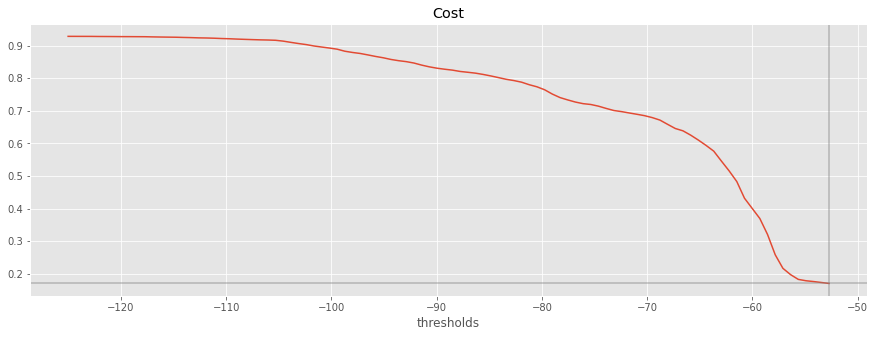

In [16]:
metrics.plot_cost(cmodel)


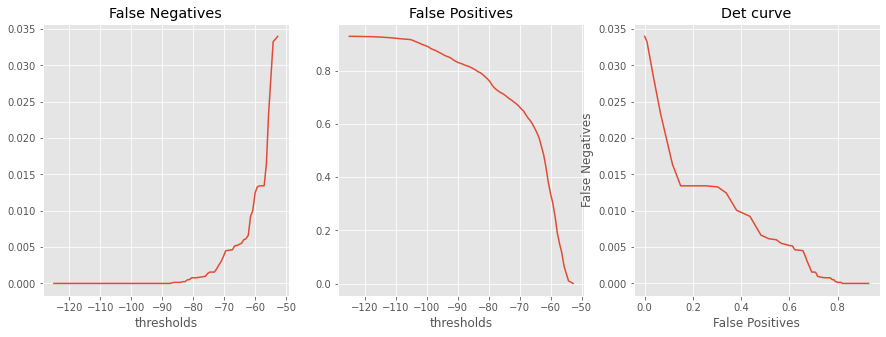

In [17]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


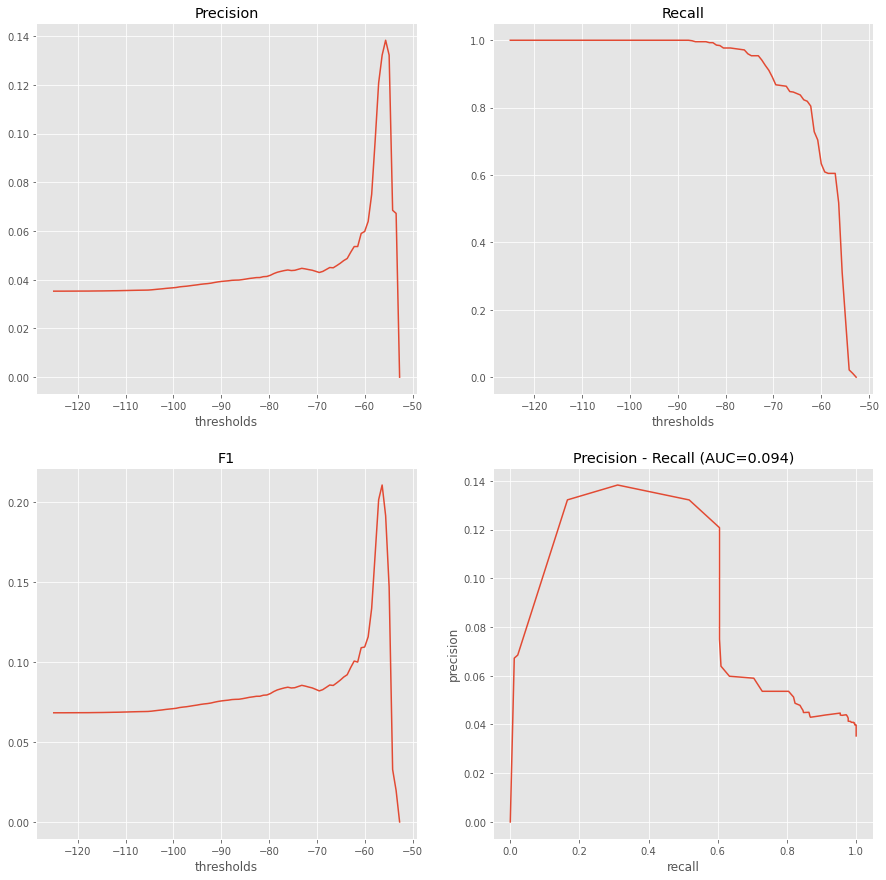

In [18]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)
